In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from joblib import Parallel, delayed, parallel_backend
# from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn, PA_with_LEDON_2
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_gamma_omega_fn, down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from diagnostics_class import Diagnostics
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_fn, CDF_RT_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz
import pickle
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn
from psiam_tied_no_dv_map_utils import rho_A_t_VEC_fn

# get og data

In [2]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


# data for vbmc

In [3]:
# LED OFF
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')

# remove ILD 16
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([16, -16]) ]
# TEMP: remove ILD 8 also
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([8, -8]) ]
print(f'len of ILD 16, 8 removed: {len(df_led_off)}')

# valid trials
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')

# remove trials with RT > 1s
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')

len of LED off: 66226
len of ILD 16, 8 removed: 39722
len of led off valid trials = 31945
len of valid trials < 1s : 31308


# condition filtered for vbmc

In [4]:
conditions = {'ABL': [40], 'ILD': [2]}


In [5]:
# Applying the filter
df_led_off_valid_trials_cond_filtered = df_led_off_valid_trials[
    (df_led_off_valid_trials['ABL'].isin(conditions['ABL'])) & 
    (df_led_off_valid_trials['ILD'].isin(conditions['ILD']))
]

In [6]:
print(f'lenm of conditioned trials = {len(df_led_off_valid_trials_cond_filtered)}')
ABLs_cond = df_led_off_valid_trials_cond_filtered['ABL'].unique()
ILDs_cond = df_led_off_valid_trials_cond_filtered['ILD'].unique()
print(ABLs_cond)
print(ILDs_cond)

lenm of conditioned trials = 1716
[40]
[2.]


# vbmc params

In [7]:
# Proactive params
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A # LED OFF

# delays
t_A_aff = -0.187
del_go = 0.13 

# other params
Z_E = 0
K_max = 10

# LED Off - no noise
noise = 0


# loglike fn

In [8]:
from psiam_tied_dv_map_utils_with_PDFs import cum_A_t_fn, cum_E_t_fn
from psiam_tied_dv_map_utils_with_PDFs import CDF_E_minus_small_t_NORM_omega_gamma_fn

def cum_pro_and_reactive(t, V_A, theta_A, t_A_aff, gamma, omega, t_stim, t_E_aff, K_max = 10):
    

    c_A = cum_A_t_fn(t- t_A_aff, V_A, theta_A)
    c_E = CDF_E_minus_small_t_NORM_omega_gamma_fn(t - t_stim - t_E_aff, gamma, omega, 1, K_max) + \
        CDF_E_minus_small_t_NORM_omega_gamma_fn(t - t_stim - t_E_aff, gamma, omega, -1, K_max)
    
    return c_A + c_E - c_A * c_E



In [9]:
def compute_loglike_trial(row, gamma, omega, t_E_aff):
    # data
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    response_poke = row['response_poke']
    

    trunc_factor_p_joint = cum_pro_and_reactive(t_stim + 1, V_A, theta_A, t_A_aff, gamma, omega, t_stim, t_E_aff) - \
                    cum_pro_and_reactive(t_stim, V_A, theta_A, t_A_aff, gamma, omega, t_stim, t_E_aff)

    choice = 2*response_poke - 5
    P_joint_rt_choice = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn(rt, V_A, theta_A, gamma, omega, t_stim, t_A_aff, t_E_aff, del_go, choice, K_max)
    

    
    P_joint_rt_choice_trunc = max(P_joint_rt_choice / (trunc_factor_p_joint + 1e-10), 1e-10)
    
    wt_log_like = np.log(P_joint_rt_choice_trunc)


    return wt_log_like


def vbmc_loglike_fn(params):
    gamma, omega, t_E_aff = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_trial)(row, gamma, omega, t_E_aff) \
                                     for _, row in df_led_off_valid_trials_cond_filtered.iterrows())
    
    return np.sum(all_loglike)

# bounds

In [10]:
gamma_bounds = [0.02, 2]
gamma_plausible_bounds = [0.09, 0.9]

omega_bounds = [0.05, 50]
omega_plausible_bounds = [0.5, 10]

t_E_aff_bounds = [0, 1]
t_E_aff_plausible_bounds = [0.01, 0.2]

# prior

In [11]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    gamma, omega, t_E_aff = params
    gamma_logpdf = trapezoidal_logpdf(gamma, gamma_bounds[0], gamma_plausible_bounds[0], gamma_plausible_bounds[1], gamma_bounds[1])
    omega_logpdf = trapezoidal_logpdf(omega, omega_bounds[0], omega_plausible_bounds[0], omega_plausible_bounds[1], omega_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    return gamma_logpdf + omega_logpdf + t_E_aff_logpdf

# prior + loglike

In [12]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

# vbmc

In [13]:
lb = np.array([gamma_bounds[0], omega_bounds[0], t_E_aff_bounds[0]])
ub = np.array([gamma_bounds[1], omega_bounds[1], t_E_aff_bounds[1]])

plb = np.array([gamma_plausible_bounds[0], omega_plausible_bounds[0], t_E_aff_plausible_bounds[0]])
pub = np.array([gamma_plausible_bounds[1], omega_plausible_bounds[1], t_E_aff_plausible_bounds[1]])

# Initialize with random values within plausible bounds
np.random.seed(42)
gamma_0 = np.random.uniform(gamma_plausible_bounds[0], gamma_plausible_bounds[1])
omega_0 = np.random.uniform(omega_plausible_bounds[0], omega_plausible_bounds[1])
t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])

x_0 = np.array([gamma_0, omega_0, t_E_aff_0])

# Run VBMC
vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Casting upper bounds to floating point.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          95.06        59.57          inf        2        inf     start warm-up
     1         15         129.66        56.20        64.37        2        inf     
     2         20         194.46        17.26       158.22        2   3.32e+03     
     3         25         377.34       117.24      3483.51        2    6.8e+04     
     4         30         299.26        21.75       741.20        2   1.46e+04     
     5         35         334.65         6.70        73.07        2   1.55e+03     
     6         40         334.02         0.05         1.11        2       23.6     
    

In [ ]:
# vbmc.save(f'vbmc_single_condn_ABL_{conditions['ABL'][0]}_ILD_{conditions['ILD'][0]}.pkl')

FileExistsError: [Errno 17] File exists: 'vbmc_single_condn_ABL_40_ILD_2.pkl'

In [ ]:
# with open(f"vbmc_single_condn_ABL_{conditions['ABL'][0]}_ILD_{conditions['ILD'][0]}.pkl", 'rb') as f:
#     vp = pickle.load(f)

# vp = vp.vp

# vbmc sample

In [15]:
vp_samples = vp.sample(int(1e5))[0]

gamma_samples = vp_samples[:, 0]
omega_samples = vp_samples[:, 1]
t_E_aff_samples = vp_samples[:, 2]

In [16]:
gamma = gamma_samples.mean()
omega = omega_samples.mean()
t_E_aff = t_E_aff_samples.mean()

# corner

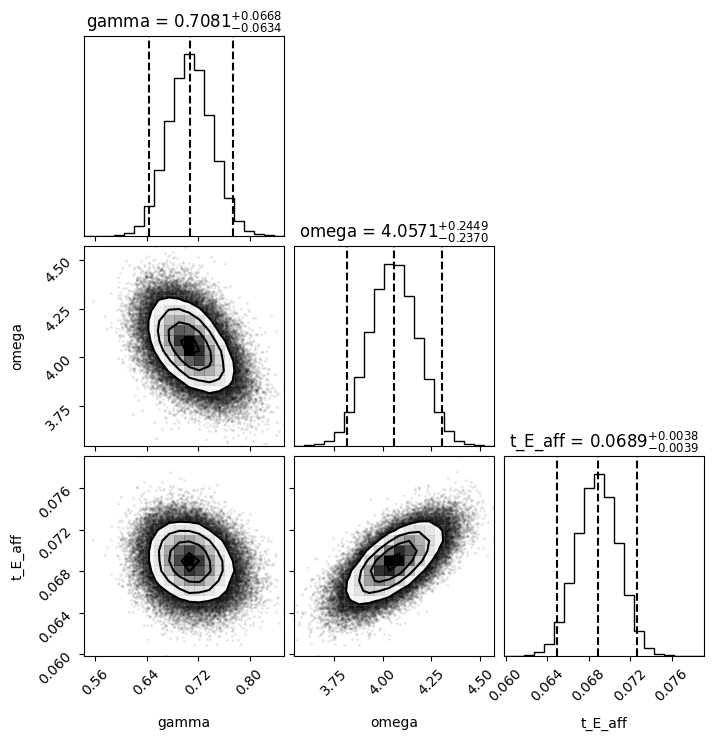

In [17]:
# plot the corner plot
corner_samples = np.vstack([gamma_samples, omega_samples, t_E_aff_samples]).T
percentiles = np.percentile(corner_samples, [0, 100], axis=0)
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(corner_samples.shape[1])]
param_labels = [ 'gamma', 'omega', 't_E_aff']

corner.corner(
    corner_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".4f"
);


# Diagnostics

## exp data df prepare

In [18]:
# DATA
df_led_off = df[df['LED_trial'] == 0]

# < 1s RTs
df_led_off = df_led_off[df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1]
# remove truncated aborts
data_df_led_off_with_aborts = df_led_off[ ~( (df_led_off['abort_event'] == 3) & (df_led_off['timed_fix'] < 0.3) ) ]
# renaming
data_df_led_off_with_aborts = data_df_led_off_with_aborts.rename(
    columns={'timed_fix': 'rt', 'intended_fix': 't_stim'}
)

### ABORTS + VALID TRIALS + ABL, ILD CONDITION
data_df_led_off_with_aborts_cond_filtered = data_df_led_off_with_aborts[
    (data_df_led_off_with_aborts['ABL'].isin(conditions['ABL'])) & 
    (data_df_led_off_with_aborts['ILD'].isin(conditions['ILD']))
]

data_df_led_off_valid = data_df_led_off_with_aborts[ data_df_led_off_with_aborts['success'].isin([1,-1]) ]

# VALID TRIALS CONDITION
df_led_off_valid_trials_cond_filtered = data_df_led_off_valid[
    (data_df_led_off_valid['ABL'].isin(conditions['ABL'])) & 
    (data_df_led_off_valid['ILD'].isin(conditions['ILD']))
]

df_led_off_valid_trials_cond_filtered['ABL'].unique(), df_led_off_valid_trials_cond_filtered['ILD'].unique()

(array([40]), array([2.]))

## up and down RT

In [19]:
# PA_with_LEDON_2(t, v, vON, a, tfix, tled, delta_A)

N_theory = int(1e3)
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(0, 1, 0.001)

P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    # pdf = PA_with_LEDON_2_VEC(t_pts, V_A, V_A_post_LED, theta_A, t_stim, t_LED, t_A_aff)
    pdf = rho_A_t_VEC_fn(t_pts - t_stim - t_A_aff, V_A, theta_A)
    P_A_samples[idx, :] = pdf

In [20]:
P_A_samples_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

In [21]:
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_fn

In [22]:
up_wrt_stim = np.zeros_like(t_pts)
down_wrt_stim = np.zeros_like(t_pts)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    up_wrt_stim[idx] =  up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, 1, K_max)
    down_wrt_stim[idx] = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, -1, K_max)


In [23]:
bins = np.arange(-1,1,0.02)
bin_centers = (bins[:-1] + bins[1:]) / 2



## data
data_up = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == 1]
data_down = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == -1]

data_up_rt = data_up['rt'] - data_up['t_stim']
data_up_rt_hist, _ = np.histogram(data_up_rt, bins=bins, density=True)

data_down_rt = data_down['rt'] - data_down['t_stim']
data_down_rt_hist, _ = np.histogram(data_down_rt, bins=bins, density=True)

frac_up_data = len(data_up) / len(df_led_off_valid_trials_cond_filtered)
frac_down_data = len(data_down) / len(df_led_off_valid_trials_cond_filtered)

areas theory up = 0.801, down = 0.195
frac up data = 0.786, down data = 0.214


Text(0, 0.5, 'density')

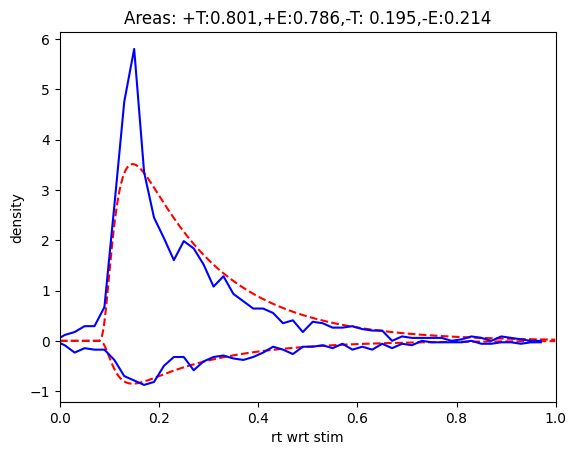

In [24]:
# RTDs - up and down
plt.plot(t_pts, up_wrt_stim, ls='--', color='r')
plt.plot(t_pts, -down_wrt_stim, ls='--', color='r')

plt.plot(bin_centers, data_up_rt_hist*frac_up_data, color='b')
plt.plot(bin_centers, -data_down_rt_hist*frac_down_data, color='b')

theory_area_up = trapz(up_wrt_stim, t_pts)
theory_area_down = trapz(down_wrt_stim, t_pts)

print(f'areas theory up = {theory_area_up :.3f}, down = {theory_area_down :.3f}')
print(f'frac up data = {frac_up_data :.3f}, down data = {frac_down_data :.3f}')
plt.xlim(0,1)
plt.title(f'Areas: +T:{theory_area_up:.3f},+E:{frac_up_data:.3f},-T:{theory_area_down: .3f},-E:{frac_down_data :.3f}')

plt.xlabel('rt wrt stim')
plt.ylabel('density')

## accuracy

In [ ]:
## 2. Accuracy
xlabels = ['data', 'vbmc']
if conditions['ILD'][0] > 0:
    accuracy_data_and_theory = [frac_up_data, theory_area_up]
else:
    accuracy_data_and_theory = [frac_down_data, theory_area_down]

plt.bar(xlabels, accuracy_data_and_theory)
plt.ylabel('accuracy')
plt.title('between stim start and stim + 1s')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1));

# tachometric

In [ ]:
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_fn

In [ ]:
# P_rt = np.zeros_like(t_pts)
tacho = np.zeros_like(t_pts)
# all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, K_max)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    if conditions['ILD'][0] > 0:
        P_rt_c = up_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_fn(t, P_A, C_A, gamma, omega, np.nan, t_E_aff, del_go, K_max)
    else:
        P_rt_c = down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_fn(t, P_A, C_A, gamma, omega, np.nan, t_E_aff, del_go, K_max)
        
    P_rt = all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, K_max)

    tacho[idx] = P_rt_c / P_rt

In [ ]:
df_led_off_valid_trials_cond_filtered_copy = df_led_off_valid_trials_cond_filtered.copy()
df_led_off_valid_trials_cond_filtered_copy.loc[:, 'RT_bin'] = pd.cut(df_led_off_valid_trials_cond_filtered_copy['rt'] - df_led_off_valid_trials_cond_filtered_copy['t_stim'],\
                                                              bins = bins, include_lowest=True)
grouped_by_rt_bin = df_led_off_valid_trials_cond_filtered_copy.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)

In [ ]:
##  3. Tacho
plt.plot(t_pts, tacho)
plt.plot(grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean'], label='data')

plt.ylim(0.5,1)
plt.xlabel('rt - t_stim')
plt.ylabel('accuracy')
plt.title('btn stim start and stim + 1s')

# combined diagnostics

# des

In [ ]:
import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import corner

# --------------------------
# Font size parameters
# Adjust these as needed
FONT_SIZE_LABEL = 22   # for x/y labels
FONT_SIZE_TICKS = 22   # for x/y tick labels
FONT_SIZE_TITLE = 22   # for subplot titles
FONT_SIZE_INSET_TITLE = 22  # for inset bar plot title

# --------------------------
# Create a figure and a GridSpec with 3 columns,
# giving the third column more space (e.g., 1.4 times the width).
fig = plt.figure(figsize=(30, 8))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 1, 1.4])

ax_rtd = fig.add_subplot(gs[0, 0])
ax_tacho = fig.add_subplot(gs[0, 1])
ax_corner = fig.add_subplot(gs[0, 2])

# ------------------------------------------------------------------------------
# 1) RTD Plot in ax_rtd
ax_rtd.plot(t_pts, up_wrt_stim, ls='--', color='r')
ax_rtd.plot(t_pts, -down_wrt_stim, ls='--', color='r')
ax_rtd.plot(bin_centers, data_up_rt_hist * frac_up_data, color='b')
ax_rtd.plot(bin_centers, -data_down_rt_hist * frac_down_data, color='b')

ax_rtd.set_xlim(0, 1)

# Set labels and title with custom font sizes
ax_rtd.set_xlabel('rt wrt stim', fontsize=FONT_SIZE_LABEL)
ax_rtd.set_ylabel('density', fontsize=FONT_SIZE_LABEL)
ax_rtd.set_title(
    f"Areas: +T:{theory_area_up:.3f},+E:{frac_up_data:.3f},"
    f"-T:{theory_area_down:.3f},-E:{frac_down_data:.3f}",
    fontsize=FONT_SIZE_TITLE
)

# Increase tick label size
ax_rtd.tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)

# Inset bar chart
inset_ax = ax_rtd.inset_axes([0.65, 0.55, 0.3, 0.4])
bar_positions = [0, 1]
inset_ax.bar(bar_positions, accuracy_data_and_theory, color=['C0', 'C1'])
inset_ax.set_xticks(bar_positions)
inset_ax.set_xticklabels(['data', 'vbmc'], fontsize=FONT_SIZE_TICKS)
inset_ax.set_ylim(0, 1)
inset_ax.set_ylabel('accuracy', fontsize=FONT_SIZE_LABEL)
inset_ax.set_title(
    f"AL={conditions['ABL'][0]},ID={conditions['ILD'][0]}",
    fontsize=FONT_SIZE_INSET_TITLE
)
inset_ax.tick_params(axis='y', which='major', labelsize=FONT_SIZE_TICKS)

# ------------------------------------------------------------------------------
# 2) Tacho Plot in ax_tacho
ax_tacho.plot(t_pts, tacho, label='tacho')
ax_tacho.plot(grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean'], label='data')
ax_tacho.set_ylim(0.5, 1)

# Set labels and title with custom font sizes
ax_tacho.set_xlabel('rt - t_stim', fontsize=FONT_SIZE_LABEL)
ax_tacho.set_ylabel('accuracy', fontsize=FONT_SIZE_LABEL)
ax_tacho.set_title('btn stim start and stim + 1s', fontsize=FONT_SIZE_TITLE)

# Increase tick label size
ax_tacho.tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)
ax_tacho.legend(fontsize=FONT_SIZE_TICKS)


## 3. Corner
fig_corner = corner.corner(
    corner_samples,
    labels=['Γ', 'ω', 'tE'],
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".4f",
    title_kwargs={"fontsize": 18}
)

# Adjust subplots to reduce margins around the corner plot.
# Tweak left, right, bottom, top until the left whitespace is minimized.
fig_corner.subplots_adjust(left=-1, right=0.95, bottom=0.15, top=0.9)

# Save with minimal padding
buf = io.BytesIO()
fig_corner.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
buf.seek(0)

# Read into an image array and close the figure
corner_img = plt.imread(buf)
plt.close(fig_corner)

# Now display in your third subplot
ax_corner.imshow(corner_img)
ax_corner.axis('off')
ax_corner.set_title('Corner Plot', fontsize=20, pad=0)

# plt.savefig("my_figure.png", dpi=300, bbox_inches="tight")
